# Start

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from PIL import Image
import math
import time
from ipywidgets import interactive
%matplotlib inline

# Pour le Kalman
import math
import time
import asyncio
import numpy as np
from tdmclient import aw, ClientAsync

# Define color thresholds in HSV
# Note: these thresholds may need to be adjusted for your specific image conditions
lower_red_bound = np.array([120, 100, 70])
upper_red_bound = np.array([255, 255, 255])
lower_green_bound = np.array([60, 50, 100])
upper_green_bound = np.array([100, 255, 255])
lower_yellow_bound = np.array([0, 50, 120])
upper_yellow_bound = np.array([40, 105, 255])
lower_black_bound = np.array([0, 0, 0])
upper_black_bound = np.array([255, 255, 130])
lower_blue_bound = np.array([90, 80, 0])
upper_blue_bound = np.array([105, 255, 255])

# Define a function to detect circles of a specific color
def detect_color_circle(image, lower_color_bound, upper_color_bound):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for the specified color
    mask = cv2.inRange(hsv, lower_color_bound, upper_color_bound)

    # Apply the mask to the original image
    color_only = cv2.bitwise_and(image, image, mask=mask)

    # Convert to grayscale for circle detection
    gray = cv2.cvtColor(color_only, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection to help with circle detection
    edges = cv2.Canny(gray, 100, 200)

    # Use Hough Transform to detect circles
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=20, param2=15, minRadius=10, maxRadius=50)
    
    # If circles are detected, return the list of circles with x, y coordinates and radius
    if circles is not None:
        # Convert the (1, N, 3) array to (N, 3)
        circles = np.uint16(np.around(circles[0, :]))          
        return [(circle[0], circle[1], circle[2]) for circle in circles]
    else:
        return []
    
def create_obstacle_mask(image, contours, kernel_size):
    """
    Create a mask with zeros in the areas inside the dilated contours.

    :param image: Input image.
    :param contours: Contours to dilate and fill in the mask.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Mask with zeros inside the dilated contours and ones elsewhere.
    """
    # Create an empty mask of the same size as the image
    h, w = image.shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)

    # Perform dilation to increase the size of the black regions
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for contour in contours:
        # Create an individual mask for each contour
        contour_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(contour_mask, [contour], 255)
        contour_mask = cv2.dilate(contour_mask, kernel, iterations=1)
        
        # Combine the individual mask with the global mask
        mask = cv2.bitwise_and(mask, cv2.bitwise_not(contour_mask))

        #also add the contours
        # Let's create a border around the image
        border_size = 50
        border_color = [0, 0, 0]  # Black border
        # Use cv2.copyMakeBorder to add a border around the image
        mask_with_border = cv2.copyMakeBorder(mask, border_size, border_size, border_size, border_size,
                                           cv2.BORDER_CONSTANT, value=border_color)
    
    return mask_with_border


# Now you have a mask with zeros in the obstacle areas and ones elsewhere
# You can return this mask from your function or process it further as needed

def detect_obstacle_contours(image, area_threshold, kernel_size):
    """
    Detects and dilates obstacle contours in the given image.
    :param image: Input image.
    :param area_threshold: Area threshold for filtering contours.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Image with obstacle contours drawn.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_black = cv2.inRange(hsv, lower_black_bound, upper_black_bound)
    contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_dilated = cv2.dilate(mask_black, kernel, iterations=1)
    dilated_contours, _ = cv2.findContours(mask_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_dilated_contours = [cnt for cnt in dilated_contours if cv2.contourArea(cnt) > area_threshold+10000]
    contour_image = image.copy()
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)
    cv2.drawContours(contour_image, filtered_dilated_contours, -1, (0, 0, 255), 2)
    return contour_image, filtered_contours, filtered_dilated_contours

def create_obstacle_matrix(image, dilated_contours):
    height, width = image.shape[:2]
    obstacle_matrix = np.ones((height, width), dtype=np.uint8)

    for contour in dilated_contours:
        # Remplir chaque contour dilaté avec 0 (obstacle)
        cv2.fillPoly(obstacle_matrix, [contour], 0)

    return obstacle_matrix

def crop_roi_from_circles(image, circles):
    if circles is not None and len(circles) >= 4:
        # Assurez-vous que les points sont dans le format correct
        points = np.array([circle[:2] for circle in circles], dtype=np.float32)

        # Calcul de la boîte englobante
        rect = cv2.boundingRect(points)

        # Recadrage de l'image
        x, y, w, h = rect
        cropped_image = image[y:y+h, x:x+w]
        return cropped_image,(x, y, w, h)
    else:
        print("Nombre insuffisant de cercles détectés ou format incorrect.")
        return image,None 
    
def find_rectangle_center(image, lower_colour_bound, upper_colour_bound, area_threshold=1000):
    # Convertir l'image en espace de couleur HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Créer un masque pour la couleur 
    mask = cv2.inRange(hsv, lower_colour_bound, upper_colour_bound)

    # Trouver les contours dans le masque
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identifier le contour qui correspond au rectangle 
    for contour in contours:
        if cv2.contourArea(contour) > area_threshold:
            # Calculer la boîte englobante pour le contour
            x, y, w, h = cv2.boundingRect(contour)

            # Effacer le rectangle en le dessinant en blanc
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), -1)

            # Calculer le centre du rectangle
            center = (x + w // 2, y + h // 2)
            return center

    return None

def robot_info(frame):
    global camera_on
    red_circles = detect_color_circle(frame, lower_red_bound, upper_red_bound)
    green_circles = detect_color_circle(frame, lower_green_bound, upper_green_bound)
    
    if red_circles and green_circles and len(red_circles) >= 2:
        # Calculate robot's position and orientation vector
        # Calculate the midpoint between the centers of the red circles
        midpoint = ((red_circles[0][0] + red_circles[1][0]) // 2,
        (red_circles[0][1] + red_circles[1][1]) // 2)
        # Calculate the directional vector
        direction = np.array([midpoint[0] - green_circles[0][0], midpoint[1] - green_circles[0][1]])

        # Normalize and extend the vector
        length = 30  # Additional length
        direction = direction / np.linalg.norm(direction) * length

        # Calculate the new endpoint
        new_endpoint = (int(green_circles[0][0] + direction[0]), int(green_circles[0][1] + direction[1]))

        # Draw the extended arrow
        cv2.arrowedLine(frame, new_endpoint, green_circles[0][:2], (0, 0, 0), 3)

        # Calculate the angle of orientation with respect to the x-axis
        dx =   midpoint[0] - green_circles[0][0]
        dy =   midpoint[1] - green_circles[0][1]
        angle = math.atan2(dy, dx)
        angle_degrees = math.degrees(angle)
        if(angle_degrees>= 0):
            angle_degrees =180 - angle_degrees
        elif (angle_degrees < 0):
            angle_degrees = -(180 + angle_degrees)
        robot_vector = (midpoint[0], midpoint[1], np.radians(angle_degrees)) #information of the robot
        #print("ANGLE ",robot_vector[2])
        # Optionally, display the angle
        cv2.putText(frame, f'Angle: {angle_degrees:.2f} degrees', (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        cv2.putText(frame, f'Midpoint: ({midpoint[0]}, {midpoint[1]})', (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        cv2.circle(frame, midpoint,10, (255, 0, 0), -1)
       # cv2.circle(frame, (x, y), r, (0, 255, 255), 3)
        camera_on = True
        return midpoint[0], midpoint[1], angle_degrees#information of the robot

    else:
        camera_on = False
        print("PASSAGE A FALSE")
        return None,None,None
    
def preprocess_image(video_capture, lower_blue_bound, upper_blue_bound):
    ret, initial_frame = video_capture.read()
    if ret:
        #initial_frame, cropping_coords = crop_largest_white_area(initial_frame, 200000)
        blue_circles = detect_color_circle(initial_frame, lower_blue_bound, upper_blue_bound)
        initial_frame ,cropping_coords= crop_roi_from_circles(initial_frame, blue_circles)
        goal_center = find_rectangle_center(initial_frame, lower_blue_bound, upper_blue_bound,2000)
        if goal_center:
            # Store the coordinates of the detected yellow circle
            yellow_circle_coords = goal_center  # center est déjà un tuple (x, y)
            radius = 10  # Rayon du cercle, vous pouvez ajuster cette valeur
            color = (0, 255, 255)  # Couleur jaune en BGR
            cv2.circle(initial_frame, yellow_circle_coords, radius, color, 3)
        robot_vector = robot_info(initial_frame)
        if robot_vector[0] and robot_vector[1]:
            cv2.circle(initial_frame, (robot_vector[0], robot_vector[1]),80, (255, 255, 255), -1)    
        contour_image = detect_obstacle_contours(initial_frame, 2000, 80)
        global_obstacle = create_obstacle_matrix(initial_frame,contour_image[2])
        # Dessiner le cercle
        initial_frame = np.flipud(initial_frame)
        plt.imshow(cv2.cvtColor(contour_image[0], cv2.COLOR_BGR2RGB))
        plt.title('Initial Contours')
        plt.axis('off')
        plt.show()
        return initial_frame, cropping_coords, contour_image, global_obstacle,goal_center, robot_vector
    else:
        return None, None, None, None, None, None
    
def process_image(frame, cropping_coords, contour_image, update_rate):
    if cropping_coords is not None:
        x, y, w, h = cropping_coords
        frame = frame[y:y+h, x:x+w]
    # Detect red and green circles
    robot_vector = robot_info(frame)
    if  robot_vector is not None:
        cv2.drawContours(frame, contour_image[1], -1, (0, 255, 0), 2)
        cv2.drawContours(frame, contour_image[2], -1, (0, 0, 255), 2)

        # Display the resulting frame
        cv2.imshow('Robot Detection', frame)
    return robot_vector

# Capture Image

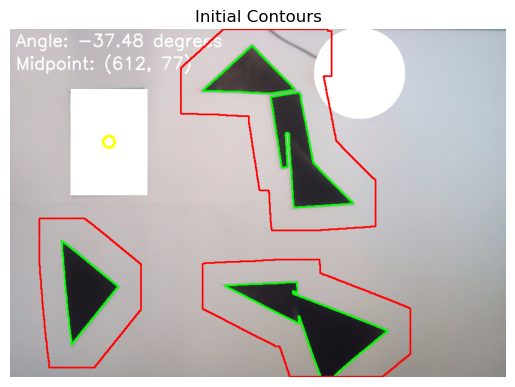

KeyboardInterrupt: 

In [2]:
video_capture = cv2.VideoCapture(1, cv2.CAP_DSHOW)

video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
window_name = 'Robot Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Resize the window (width, height)
cv2.resizeWindow(window_name, 540, 360)  

# Initial detection of obstacles and goal
initial_frame, cropping_coords, contour_image, global_obstacle,goal_center, robot_pose = preprocess_image(video_capture, lower_blue_bound, upper_blue_bound)
# Robot update frequency (10 Hz)
update_rate = 0.01  # 10 times per second
if initial_frame is not None:
    try:
        while True:
            start_time = time.time()
            ret, frame = video_capture.read()
            if not ret:
                break
            robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)

            # Pause to maintain the update frequency
            time_to_wait = max(int((start_time + update_rate - time.time()) * 1000), 1)
            if cv2.waitKey(time_to_wait) & 0xFF == ord('q'):
                break

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Release the capture when everything is finished
        video_capture.release()
        cv2.destroyAllWindows()

# Next

(173, 197)
(611, 76, -37.74680538727466)
[603.          86.          -0.65880604]
 Time for  25  :  0.1067357063293457
[[ 75 100 125 150 175 200 225 250 275 300 325 350 375 375 375 375 375 375
  375 375 375 375 375 375 375 350 325 300 275 250 225 200 175]
 [600 600 600 600 600 600 625 650 675 675 675 675 650 625 600 575 550 525
  500 475 450 425 400 375 350 325 300 275 250 225 200 175 150]]


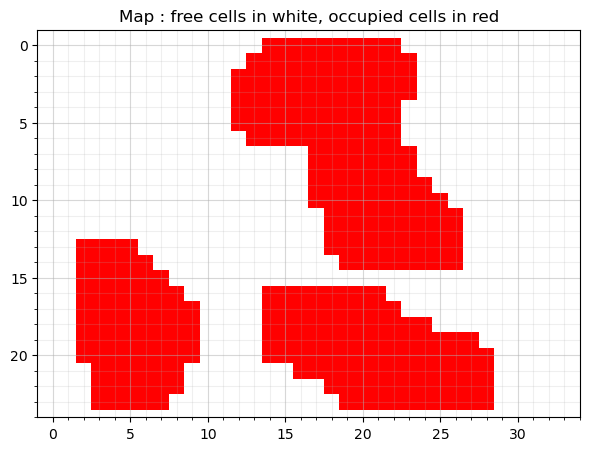

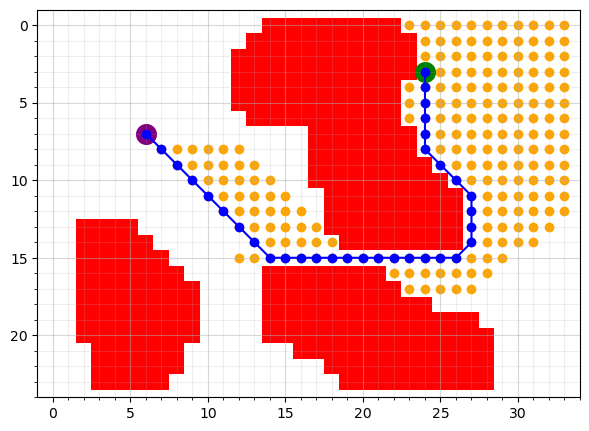

In [3]:
def x_robot_projection_to_ground(x_pos_robot):
    return round(0.96*x_pos_robot+16.67)
    
def y_robot_projection_to_ground(y_pos_robot):
    return round(0.95*y_pos_robot+14.29)

print(goal_center)
print(robot_pose)
robot_vector = np.zeros(3)
robot_vector[0] = int(x_robot_projection_to_ground(robot_pose[0]))
robot_vector[1] = int(y_robot_projection_to_ground(robot_pose[1]))
robot_vector[2] = np.radians(robot_pose[2])
print(robot_vector)

global_obstacle = np.logical_not( global_obstacle )
max_val_x_init = global_obstacle.shape[0]
max_val_y_init = global_obstacle.shape[1]

reduction_coeff = 25 # tune for speed
max_val_x = int(max_val_x_init / reduction_coeff)
max_val_y = int(max_val_y_init / reduction_coeff)

occupancy_grid = np.zeros((max_val_x, max_val_y), dtype=int)
for i in range (max_val_x):
    for j in range (max_val_y):
        sum_pixels = 0
        for k in range (reduction_coeff): # dans le doute on augmente la distance de sécurité avec obstacle
            
            indice_x = int(i * reduction_coeff - reduction_coeff/2 + k)
            if (indice_x < 0):
                indice_x = 0
            elif (indice_x > (max_val_x_init - 1)):
                indice_x = max_val_x_init -1
            
        
            indice_y = int(j * reduction_coeff - reduction_coeff/2 + k)
            if (indice_y < 0):
                
                indice_y = 0
            elif (indice_y > (max_val_y_init - 1)):
                indice_y = max_val_y_init -1
            
            sum_pixels = sum_pixels + global_obstacle[indice_x][indice_y]
            

            
        if sum_pixels == 0:
            occupancy_grid[i][j] = 0
        else:
            occupancy_grid[i][j] = 1
            
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    #ax.set_ylim([-1,max_val_x])
    ax.set_ylim([max_val_x,-1])
    ax.set_xlim([-1,max_val_y])
    ax.grid(True)
    
    return fig, ax

# Printing the grid

fig, ax = create_empty_plot(max_val_y)

cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

# Displaying the map
ax.imshow(occupancy_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]


def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", max_val_x=max_val_x, max_val_y=max_val_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val_y, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]
    
    current = ([0,0])

    # while there are still elements to investigate
    while openSet != []:
        
        previous = current
        
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            ROTATION_COST = 1
            
            if(not (current == start)):
                #print(cameFrom)
                vector_prev = ([current[0] - (cameFrom[current])[0], current[1] - (cameFrom[current])[1]]) 
                vector_next = ([neighbor[0] - current[0], neighbor[1] - current[1]]) 
                angle = np.arccos(np.dot(vector_prev, vector_next) / (np.linalg.norm(vector_prev) * np.linalg.norm(vector_next)))
                rotation_cost = angle * ROTATION_COST
            else:
                rotation_cost = 0
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost + rotation_cost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

# Define the start and end goal
start = (int(robot_vector[1]/reduction_coeff),int(robot_vector[0]/reduction_coeff))
goal = (int(goal_center[1]/reduction_coeff),int(goal_center[0]/reduction_coeff))

# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
w,z = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(w.shape + (2,))
pos[:, :, 0] = w; pos[:, :, 1] = z
pos = np.reshape(pos, (w.shape[0]*w.shape[1], 2))
coords = list([(int(w[0]), int(w[1])) for w in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
start_time = time.time()

path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")

end_time = time.time()
elapsed_time = end_time - start_time
print(" Time for ", reduction_coeff, " : ", elapsed_time)

path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

path_final = path * reduction_coeff

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val_y)
ax_astar.imshow(occupancy_grid, cmap=cmap)
print(path_final)
# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[1], visitedNodes[0], marker="o", color = 'orange');
ax_astar.plot(path[1], path[0], marker="o", color = 'blue');
ax_astar.scatter(start[1], start[0], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);

path_final[[0,1]] = path_final[[1,0]] 
path_final[0][0] = robot_vector[0]
path_final[1][0] = robot_vector[1]
path_final[0][-1] = goal_center[0]
path_final[1][-1] = goal_center[1]

def filter_initialization():
    """
    Initialize the various vectors and matrices requiered for filtering
    
    robot_vector: position (x and y) and orientation taken from the camera vision
    """
    
    global s_prev_est_a_posteriori, P_prev_est_a_posteriori, A, B, u, C, Q, R

    ## Previous State A Posteriori Estimation Vector
    # Vector representing the estimated state of the system at the previous time step
    s_prev_est_a_posteriori = robot_vector
       
    ## Previous State A Posteriori Covariance Matrix
    # Matrix representing the estimated precision of the previous estimated state
    P_prev_est_a_posteriori = np.array([[1, 0, 0], 
                                        [0, 1, 0], 
                                        [0, 0, 0.01]]) 
    
    ## State Matrix
    # Matrix defining how the system evolves from one time step to the next
    A = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
        
    ## Input Matrix 
    # Matrix describing the impact of the input on the state
    B = np.array([[1, 0], 
                  [0, 1], 
                  [0, 0]]); 
        
    ## Input Vector
    # Vector representing control inputs applied to the system 
    u = np.array([0, 0])
    
    ## Output Matrix
    # Matrix linking measurements to state
    C = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
        
    ## Process Noise Covariance Matrix
    # Covariance matrix representing uncertainty in system dynamics
    Q = np.array([[4, 0, 0], 
                  [0, 4, 0], 
                  [0, 0, 0.03]])
    
    ## Measurement Noise Covariance Matrix
    # Matrix representing uncertainty of camera measurements
    R = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 0.01]])

def update_input(v_l,v_r,update_time, direction_rotation):
    """
    Update the input vector and matrix
    
    v_l: robot x position deduced from the camera vision
    v_r: robot y position deduced from the camera vision
    update_time: robot theta orientation deduced from the camera vision
    """
    
    global B,u
    
    Thymio_to_mms = 0.349
    mm_to_px = 100/137
    
    # Average translational speed
    v = (v_r +v_l)/2 # Thymio speed (T)
    v = v * Thymio_to_mms * mm_to_px # Speed in px/s (T -> mm/s -> px/s)

    # Average rotational speed
    w = (v_r -v_l)*Thymio_to_mms/robot_diameter # Angular speed in rad/s
    
    if (direction_rotation == TURN_RIGHT):
        w = -w
    
    # Input vector
    u = np.array([v, w]) 
    
    # Angle variation
    delta_theta = w * update_time
    
    # Input matrix
    B = np.array([[np.cos(delta_theta + s_prev_est_a_posteriori[2])*update_time, 0],
                  [-np.sin(delta_theta + s_prev_est_a_posteriori[2])*update_time, 0], 
                  [0, update_time]]); 

def kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori):
    """
    Estimates the current state using the input sensor data and the previous state
    
    param s_prev_est_a_posteriori: previous state a posteriori estimation
    param P_prev_est_a_posteriori: previous state a posteriori covariance
    
    return s_est_a_posteriori: new a posteriori state estimation
    return P_est_a_posteriori: new a posteriori state covariance
    """
    
    ## Prediciton through the a priori estimate
    # estimated mean of the state
    s_est_a_priori = np.dot(A, s_prev_est_a_posteriori)+ np.dot(B, u);
    path_apriori.append(s_prev_est_a_posteriori)
    
    # Estimated covariance of the state
    P_est_a_priori = np.dot(A, np.dot(P_prev_est_a_posteriori, A.T)) + Q
    
    ## Update         
    # m, C, and R for a posteriori estimate, depending on the detection of the camera
    if camera_on == True:
        m = robot_vector
        path_camera.append(m)
        # innovation / measurement residual
        i = m - np.dot(C, s_est_a_priori);
        # measurement prediction covariance
        S = np.dot(C, np.dot(P_est_a_priori, C.T)) + R;     
        # Kalman gain (tells how much the predictions should be corrected based on the measurements)
        K = np.dot(P_est_a_priori, np.dot(C.T, np.linalg.inv(S)));
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori + np.dot(K,i);
        P_est_a_posteriori = P_est_a_priori - np.dot(K,np.dot(C, P_est_a_priori));
    else:
        K = 0 # Kalman gain is null because the camera can't deliver any data
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori;
        P_est_a_posteriori = P_est_a_priori;
        
    return s_est_a_posteriori, P_est_a_posteriori

# Thymio connection
async def connect_Thymio():
    """
    Establish a connection with the Thymio if possible
    """
    global node, client
    try:
        client = ClientAsync()
        node = await asyncio.wait_for(client.wait_for_node(), timeout=2.0)
        await node.lock()
        print("Thymio connected")

    except asyncio.TimeoutError:
        print("Thymio not connected: Timeout while waiting for node.")
    except Exception as e:
        print(f"Thymio not connected: {str(e)}")
        
# Thymio disconnection
def disconnect_Thymio():
    """
    Enable to disconnect the Thymio
    """
    aw(node.stop())
    aw(node.unlock())
    print("Thymio disconnected")
    
# Thymio set motors speeds  
async def set_speeds(left_speed, right_speed):
    """
    Enable to set the speed of the Thymio's wheels
    """
    global node
    v = {
        "motor.left.target":  [left_speed],
        "motor.right.target": [right_speed],
    }
    await node.set_variables(v)
    
# Thymio motors stop     
async def motors_stop():
    """
    Stop the Thymio
    """
    global node
    v = {
        "motor.left.target":  [0],
        "motor.right.target": [0],
    }
    await node.set_variables(v)    
    
Thymio_to_mms = 0.349
px_to_mm = 137/100

ROTATION_SPEED = 100
TIME_FULL_TURN = (8800/1000)

# Thyimo turns a specied angle
async def turn(angle):
    # Calculate the time needed to turn through the required angle
    rotation_time = (abs(angle) / (2*np.pi)) * TIME_FULL_TURN

    # Turn robot on itself
    # Check the sign of angle
    if np.sign(angle) > 0:
        # If angle is positive, turn left
        await set_speeds(-ROTATION_SPEED, ROTATION_SPEED)
        left_or_right = TURN_LEFT
    else:
        # If angle is negative, turn right
        await set_speeds(ROTATION_SPEED, -ROTATION_SPEED)
        left_or_right = TURN_RIGHT

    # Wait required time
    time.sleep(rotation_time)
    return rotation_time, left_or_right

# Constants
FORWARD_SPEED = 200  # Base speed
TIME_PER_MM = 15.5/1000  # Time it takes for the robot to travel one meter at base speed

async def move_forward(distance_px):
    # Calculate the time needed to travel the requested distance
    
    distance_mm = distance_px * px_to_mm
    travel_time = (distance_mm) * TIME_PER_MM
    
    # Robot moves forward
    await set_speeds(FORWARD_SPEED, FORWARD_SPEED)

    # Wait for the necessary time
    time.sleep(travel_time)
    return travel_time

async def reach_next_node(next_node, mode, estimated_pos):

    # Normal vector
    vector_next_node = np.array([0,0])  
    vector_next_node[0] = path_final[0][next_node] - estimated_pos[0]
    vector_next_node[1] = path_final[1][next_node] - estimated_pos[1] 
    
    # angle gamma
    gamma = -math.atan2(vector_next_node[1], vector_next_node[0]) - estimated_pos[2]
    gamma = (gamma + np.pi) % (2*np.pi) - np.pi
    
    # distance d
    path_next_node = np.array([path_final[0][next_node], path_final[1][next_node]])
    path_current_node = np.array([estimated_pos[0], estimated_pos[1]])
    d = np.linalg.norm(path_next_node - path_current_node)
    
    if(not mode):
        if(abs(gamma) > ANGLE_THRESHOLD):
            time_r, left_or_right = await turn(gamma)
        else: 
            time_r = 0 
            left_or_right = 1  
        return time_r, left_or_right 
        
    if (mode):
        if( d > FORWARD_THRESHOLD):
            time_f = await move_forward(d)
            return time_f
        
# Global variables

# general
next_node = 1
turn_left_or_right = 0
path_followed = []
path_apriori = []
path_camera = []

#Filtering
camera_on = False                # Boolean that determines whether the camera has vision or not
robot_diameter = 94              # Distance between the two wheels

# Constants
ROTATION_MODE = 0
FORWARD_MODE = 1
ANGLE_THRESHOLD = 0.0
FORWARD_THRESHOLD = 1
ROTATION_TIME_THRESHOLD = 1.2
FORWARD_TIME_THRESHOLD = 100
TURN_RIGHT=0
TURN_LEFT=1

## Main

Without camera

In [4]:
camera_on = False  

await connect_Thymio()

filter_initialization()
#print(s_prev_est_a_posteriori)
path_followed.append(s_prev_est_a_posteriori)

while True:
    # Rotation
    time_rotation, turn_left_or_right = await reach_next_node(next_node, ROTATION_MODE, s_prev_est_a_posteriori)
    update_input(-ROTATION_SPEED, ROTATION_SPEED, time_rotation, turn_left_or_right)
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    #print(s_prev_est_a_posteriori)

    # Linear displacement
    forward_time = await reach_next_node(next_node, FORWARD_MODE , s_prev_est_a_posteriori)
    update_input(FORWARD_SPEED, FORWARD_SPEED, forward_time, 1)
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    #print(s_prev_est_a_posteriori)
    
    path_followed.append(s_prev_est_a_posteriori)
    
    next_node += 1
    
    if (next_node == path_final.shape[1]):
        break
    
await motors_stop()
disconnect_Thymio()
path_followed = np.array(path_followed)
#print(path_followed)
print("Thymio ready for the game!")

Thymio connected
Thymio disconnected
Thymio ready for the game!


With camera

In [ ]:
rotation_on = True  

await connect_Thymio()

# Initialize video capture
video_capture = cv2.VideoCapture(1, cv2.CAP_DSHOW)
video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
video_capture.set(cv2.CAP_PROP_BUFFERSIZE,1)

if not video_capture.isOpened():
    raise IOError("Could not load the camera")

window_name = 'Robot Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Resize the window (width, height)
cv2.resizeWindow(window_name, 540, 360)  

time.sleep(1)
ret, frame = video_capture.read()
robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)
time.sleep(1)

# Initial detection of obstacles and goal
#initial_frame, cropping_coords, contour_image, global_obstacle,goal_center, robot_pose = preprocess_image(video_capture, lower_blue_bound, upper_blue_bound)
# Robot update frequency (10 Hz)


filter_initialization()
#print(s_prev_est_a_posteriori)
path_followed.append(s_prev_est_a_posteriori)

try:
    while True:
        if rotation_on: 
            
            # Rotation
            time_rotation, turn_left_or_right = await reach_next_node(next_node, ROTATION_MODE, s_prev_est_a_posteriori)
            await motors_stop()
            update_input(-ROTATION_SPEED, ROTATION_SPEED, time_rotation, turn_left_or_right)

            #####################################
            time.sleep(1)

            ret, frame = video_capture.read()
            robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)


            if camera_on:
                robot_vector[0] = int(x_robot_projection_to_ground(robot_pose[0]))
                robot_vector[1] = int(y_robot_projection_to_ground(robot_pose[1]))
                robot_vector[2] = np.radians(robot_pose[2])
                print("ROBOT_VECTOR après rotation :", robot_vector)
            time.sleep(1)
            
            ##################################### 
            s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
            rotation_on = False
            
        else:

            # Linear displacement
            forward_time = await reach_next_node(next_node, FORWARD_MODE , s_prev_est_a_posteriori)
            await motors_stop()
            update_input(FORWARD_SPEED, FORWARD_SPEED, forward_time, 1)
            
            #####################################
            
            time.sleep(1)
            ret, frame = video_capture.read()
            robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)
            if camera_on:
                robot_vector[0] = int(x_robot_projection_to_ground(robot_pose[0]))
                robot_vector[1] = int(y_robot_projection_to_ground(robot_pose[1]))
                robot_vector[2] = np.radians(robot_pose[2])
            end_time = time.time()
            time.sleep(1)
            
            ##################################### 
    
            s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
            rotation_on = True

        path_followed.append(s_prev_est_a_posteriori)

        next_node += 1

        if (next_node == path_final.shape[1]):
            break
        # Pause to maintain the update frequency
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    await motors_stop()
    disconnect_Thymio()
    path_followed = np.array(path_followed)
    path_apriori = np.array(path_apriori)
    path_camera = np.array(path_camera)
    #print(path_followed)
    print("Thymio ready for the game!")
    
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Release the capture when everything is finished
    video_capture.release()
    cv2.destroyAllWindows()

# Plot

In [ ]:
# Displaying the map
fig_astar, ax = create_empty_plot(max_val_y)
ax.imshow(occupancy_grid, cmap=cmap)
#print(path_final)
#print(path_followed)
# Plot the best path found and the list of visited nodes
#ax.plot(path[1], path[0], marker="o", color = 'blue');
ax.scatter(start[1], start[0], marker="o", color = 'green', s=200);
ax.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);
x = path_followed[:, 0]/reduction_coeff
y = path_followed[:, 1]/reduction_coeff
x2 = path_apriori[:, 0]/reduction_coeff
y2 = path_apriori[:, 1]/reduction_coeff
x3 = path_camera[:, 0]/reduction_coeff
y3 = path_camera[:, 1]/reduction_coeff
#ax.scatter(x, y, marker="o", color = 'cyan')
#ax.scatter(x2, y2, marker="x", color = 'orange')
ax.scatter(x3, y3, marker="o", color = 'pink')
ax.plot(x, y, color = 'cyan')
plt.show()
#print(path_camera)
print(path_camera)